# Overview

In this tutorial we will review key modern CNN architecture motifs and discuss implementation strategies using Tensorflow 2 / Keras.

**Modern Architectures**

* residual connection
* bottleneck operation
* Inception module
* Squeeze-and-Excite (SE) module

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [1]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 89 kB 2.6 MB/s 
     |████████████████████████████████| 596 kB 34.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries:

In [2]:
import numpy as np, pandas as pd
from tensorflow.keras import Input, Model, models, layers, losses, metrics, optimizers
from jarvis.train import datasets
from jarvis.utils.display import imshow

# Data

The data used in this tutorial will consist of kidney tumor CT exams derived from the Kidney Tumor Segmentation Challenge (KiTS). More information about he KiTS Challenge can be found here: https://kits21.kits-challenge.org/. In this exercise, we will use this dataset to derive a model for slice-by-slice kidney detection. The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/ct_kits`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [3]:
# --- Download dataset
datasets.download(name='ct/kits-128')

[ 2022-04-22 16:03:04 ] [====================] 100.000% : Extracting archive (0000418 / 0000418) 

{'code': '/data/raw/ct_kits', 'data': '/data/raw/ct_kits'}

Once downloaded, the `datasets.prepare(...)` method can be used to generate the required python Generators to iterate through the dataset, as well as a `client` object for any needed advanced functionality. As needed, pass any custom configurations (e.g. batch size, normalization parameters, etc) into the optional `configs` dictionary argument. 

To specificy the correct Generator template file, pass a designated `keyword` string. In this tutorial, we will be using abdominal CT volumes that have been preprocessed into 128 x 128 matrix images, each derived from a *mean intensity projection* (MeanIP) algorithm to approximately 5 mm in slice thickness, facilitating ease of algorithm training within the Google Colab platform. To select the correct Client template for this task, use the keyword string `128*cls`. 

In [4]:
# --- Prepare generators
gen_train, gen_valid, client = datasets.prepare(name='ct/kits-128', keyword='128*glb')

The created generators yield a total of `batch['size']` training samples based on the specified batch size. As before, each iteration yields dictionary of model inputs, `xs`. In the current example, there is just a single input image `xs['dat']` and a single target `xs['lbl']`. Let us examine the generator data:

In [5]:
# --- Yield one example
xs, _ = next(gen_train)

# --- Print dict keys
for k, v in xs.items():
    print('key = {} : shape = {}'.format(k.ljust(7), v.shape))

key = dat     : shape = (8, 1, 128, 128, 1)
key = lbl     : shape = (8, 1, 1, 1, 1)


### KITS Data

The input images in the variable `dat` are matrices of shape `1 x 128 x 128 x 1`. Note that even though the images here are 2D in shape, the full matrix is a 3D tensor `(z, y, x)` where `z = 1` in this implementation. Note that although the 3rd z-axis dimension is redundant here (for a single slice input), many of our more complex models and architectures will commonly require a full 3D tensor. Because of this, we will directly use 3D convolutions throughout the tutorial materials for consistency.

Use the following lines of code to visualize using the `imshow(...)` method:

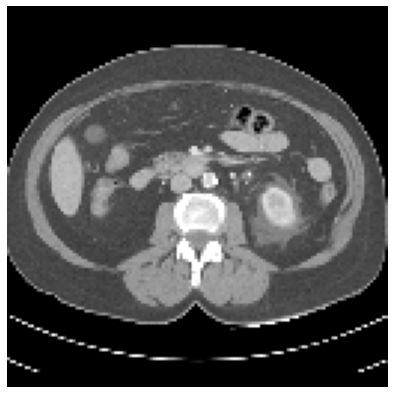

In [6]:
# --- Show the first example
imshow(xs['dat'][0])

Use the `montage(...)` function to create an N x N mosaic of all images:

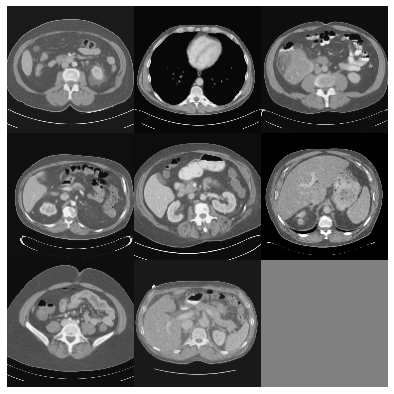

In [7]:
# --- Show "montage" of all images
imshow(xs['dat'])

As expected, the `xs['lbl']` vector corresponds to ground-truth, whereby:
* class `0`: no kidney
* class `1`: kidney

In [8]:
# --- Print xs['lbl']
print(xs['lbl'])

[[[[[1]]]]



 [[[[0]]]]



 [[[[1]]]]



 [[[[1]]]]



 [[[[1]]]]



 [[[[1]]]]



 [[[[0]]]]



 [[[[1]]]]]


# Residual Layer

Recall the multiple options for creating a residual connection:

![Diagramtric Representation](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2022/notebooks/detection/pngs/residual.png)

In this tutorial, we will recreate the highest performing residual connection implemented using **full pre-activation**. 

Let us first begin by defining a single `Input` variable `x`:

In [55]:
# --- Define model input 
x = Input(shape=(None, 128, 128, 1), dtype='float32')

As in the prior tutorial, let us set up the same lambda functions for CNN definition:

In [10]:
# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same'}

# --- Define lambda functions
conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)

Now instead of our standard block, let us define a **full pre-activation** block instead:

* `[ conv - norm - relu ]` ==> original (standard) 
* `[ norm - relu - conv ]` ==> full pre-activation

In [11]:
# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : conv(relu(norm(x)), filters, strides=1)
conv2 = lambda filters, x : conv(relu(norm(x)), filters, strides=(1, 2, 2))

To seed a **full pre-activation** ResNet, start by applying a naive convolution (no activation) to the first input layer:

In [12]:
# --- First standard conv layer
l0 = conv(x, filters=16, strides=1) 

For the remaining network blocks, implementation of a residual function is straightforward as recent versions of Tensorflow / Keras layers can utilize the native Python addition `+` operator directly:

In [13]:
# --- Define blocks
l1 = conv1(16, l0)
l2 = conv1(16, l1)

# --- Define third block with residual connection
l3 = conv1(16, l2) + l1

### Projection

Note that layers can added **only if** the layer sizes match exactly. What happens if the total number of feature maps (e.g. layer depth) is different? The solution is use of the `1 x 1` projection matrix (e.g. convolutional operation without corresponding nonlinearity). Here the third and fourth dimension of the convolutional kernel are designed to match the number of channels in the input and target output tensors, respectively:

```
filter size = I x J x C0 x C1

I  ==> 1
J  ==> 1
C0 ==> # of channels in input tensor
C1 ==> # of channels in output tensor
```

Recall that in Tensorflow, only the output layer channel size needs to be defined (the third channel of the convolutional kernel is inferred based on the input tensor). Consider the following example:

In [14]:
# --- Define blocks
l1 = conv1(16, l0)
l2 = conv1(32, l1)

# --- Define third block with residual connection
l3 = conv1(32, l2) # + l1 would not work

At this point, `l1` cannot be added since dimensions do not match. Thus consider the following projection operation:

In [15]:
# --- Define projection
proj = lambda filters, x : layers.Conv3D(
    filters=filters, 
    strides=1, 
    kernel_size=(1, 1, 1),
    padding='same')(x)

# --- Define third block with residual connection
l3 = conv1(32, l2) + proj(32, l1)

What about differences not only in channel depth but also feature map size?

In [16]:
# --- Define blocks
l1 = conv1(16, l0)
l2 = conv2(32, l1)

# --- Define third block with residual connection
l3 = conv1(32, l2) # + l1 would not work

To match the subsample operation, the projection operation now also must strided as well. Given this, it may be useful to increase the `kernel_size` of the project operation as you recall so that all activations are contributing to the output projection tensor:

In [17]:
# --- Define projection
proj = lambda filters, x : layers.Conv3D(
    filters=filters, 
    strides=(1, 2, 2), 
    kernel_size=(1, 1, 1),
    padding='same')(x)

# --- Define third block with residual connection
l3 = conv1(32, l2) + proj(32, l1)

### Bottleneck

![Bottleneck](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2022/notebooks/detection/pngs/bottleneck.png)

Bottleneck operations are used to decrease the total number of feature maps (filters) for convolutional efficiency. They are similar to projection operations in that both utilize a `1 x 1 x 1` convolutional kernel, however a bottleneck operation includes a nonlinearity term e.g., it is defined as a full convolutional *block*. 

In [18]:
# --- Define projection
bneck = lambda filters, x : layers.Conv3D(
    filters=filters, 
    strides=1, 
    kernel_size=(1, 1, 1),
    padding='same')(relu(norm(x)))

# --- Define standard conv-conv block
l1 = conv1(32, l0)
l2 = conv1(32, l1)

# --- Define bottleneck conv-conv block
l1 = conv1(32, l0)
l2 = bneck(32, conv1(8, bneck(8, l1)))

In [19]:
conv1(32,l0)

<KerasTensor: shape=(None, None, 128, 128, 32) dtype=float32 (created by layer 'conv3d_20')>

In [20]:
bneck(8,l1)

<KerasTensor: shape=(None, None, 128, 128, 8) dtype=float32 (created by layer 'conv3d_21')>

In [21]:
conv1(8, bneck(8, l1))

<KerasTensor: shape=(None, None, 128, 128, 8) dtype=float32 (created by layer 'conv3d_23')>

In [22]:
bneck(32, conv1(8, bneck(8,l1)))

<KerasTensor: shape=(None, None, 128, 128, 32) dtype=float32 (created by layer 'conv3d_26')>

What is the computational efficiency of the bottleneck vs. the standard conv block in this example?

# Inception

Recall the definition of an Inception module:

![Inception](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2021/notebooks/detection/pngs/inception.png)

Let us first implement a naive Inception module without any bottlenecks. Recall that we will need four different paths implemented:

* 1x1 convolution
* 3x3 convolution
* 5x5 convolution
* 3x3 max-pool

Let us define these building blocks with the following lambda functions:

In [23]:
# --- Define lambda functions
conv = lambda x, filters,kernel_size : layers.Conv3D(
    filters=filters, 
    kernel_size=kernel_size, 
    padding='same')(x)

norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)

# --- Define 1x1, 3x3, 5x5 convs and 3x3 pools
conv1 = lambda filters, x : relu(norm(conv(x, filters, kernel_size=(1, 1, 1))))
conv3 = lambda filters, x : relu(norm(conv(x, filters, kernel_size=(1, 3, 3))))
conv5 = lambda filters, x : relu(norm(conv(x, filters, kernel_size=(1, 5, 5))))
mpool = lambda x : layers.MaxPool3D(pool_size=(1, 3, 3), strides=1, padding='same')(x)

Note that in the above implementation, max-pooling is used as a standard layer without any subsampling.

Let us now use these lambda functions to create a test Inception module:

In [24]:
# --- Define first layer operation
l1 = conv3(16, x)

# --- Define four different paths
filters = 16
p1 = conv1(filters, l1)
p2 = conv3(filters, l1)
p3 = conv5(filters, l1)
p4 = mpool(l1)

# --- Concatenate
l2 = layers.Concatenate()([p1, p2, p3, p4])

As discussed, naive implementation of the Inception module yields large channel depths over time. To avoid this, use bottleneck operations. In the current code blocks, note that the `conv1` lambda function e.g., 1 x 1 convolution, can be used for this purpose.

In [25]:
# --- Define first layer operation
l1 = conv3(16, x)

# --- Define four different paths
filters = 4
p1 = conv1(filters, l1)
p2 = conv3(filters, conv1(filters, l1))
p3 = conv5(filters, conv1(filters, l1))
p4 = conv1(filters, mpool(l1))

# --- Concatenate
l2 = layers.Concatenate()([p1, p2, p3, p4])

# Squeeze-and-Excite

Recall the definition of a squeeze-and-excite module:

![SENet](https://pbs.twimg.com/media/DO25715W0AAxIKA.jpg)

### SE Module

The SE module is a simple modification that can be applied to any existing architecture. Starting with the output of any standard convolutional block (e.g., convolution and activation function), the intermediate feature map is scaled by a constant value independently across all channels to *emphasize* the important features for any given single image (or volume). The scaling values are learned via an SE block, which is characterized by several key features:

```
# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(1, 2, 2))))
```

* **squeeze**: collapse of N x N feature maps to 1 x 1 feature vectors via global pooling
* **excitation**: two fully connected layers to model channel-wise (feature-wise) interdependencies
* **scale**: scaling all feature maps by the learned *excitation* values

Start this implementation by creating a first layer feature map:

In [26]:
# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same'}

# --- Define lambda functions
conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(1, 2, 2))))

# --- Define model
l1 = conv1(32,  x)

Use the following lines of code to modify the output feature map `l1` by a scalar vector:

In [51]:
# --- Squeeze (global pool)
sqz = layers.AveragePooling3D((1, l1.shape[2], l1.shape[3]))(l1)

# --- Excitation (reduce channels to 1 / R) ==> in this example set R = 4 arbitrarily
cha = int(l1.shape[-1] / 4)
exc = layers.Conv3D(filters=cha, kernel_size=1, activation='relu')(sqz)

# --- Scale (expand channels to original size)
sca = layers.Conv3D(filters=l1.shape[-1], kernel_size=1, activation='sigmoid')(exc)

# --- Modify l1
l1 = l1 * sca

In [28]:
cha = int(l1.shape[-1]/4)

In [29]:
cha

8

In [30]:
sca

<KerasTensor: shape=(None, None, 1, 1, 32) dtype=float32 (created by layer 'conv3d_40')>

In [52]:
l1.shape

TensorShape([None, None, 128, 128, 32])

Now that `l1` has been modified, it can be passed to the next layer exactly as before (e.g., with another `conv1(...)` or `conv2(...)` operation.

# Creating Models

Let us compile a temporary model for purposes of demontrating evaluation procedure. Note that in this example, no special motifs are used.

## Backbone model

Using the concepts introduced above, let us start by recreating the base `backbone` model (e.g., without training dependencies). Use the following line of code to create the `backbone` model:

In [56]:
# --- Define convolution parameters
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same',
    'kernel_initializer': 'he_normal'}

# --- Define block components
conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(1, 2, 2)))) 

In [57]:
# --- Define model
l1 = conv1(32,  x)
l2 = conv1(48,  conv2(48,  l1))
l3 = conv1(64,  conv2(64,  l2))
l4 = conv1(80,  conv2(80,  l3))
l5 = conv1(96,  conv2(96,  l4))
l6 = conv1(128, conv2(128, l5))

### Transition from CNN to MLP

At this point of the model, to convert from CNN to MLP architecture, the `(1, N, N, C)` feature maps need to be collapsed into vector form. A `layers.Flatten()` operation may accomplish this by converting our feature map to a single `(1 * N * N * C,)` vector. An alternative to this is to use a `layers.Reshape()` operation to convert our feature map to a `(1, 1, 1, N * N * C)` feature map; subsequently, any additional 3D convolutional operation with kernel size `(1, 1, 1, C-in, C-out)` will be **identical** to a matrix multiply operation.

In other words:

```
input          | output                | output type    | downstream matrix multiply operations
---------------------------------------------------------------------------------------------------
(1, N, N, C)   | (N * N * C,)          | vector         | layers.Dense(...)
(1, N, N, C)   | (1, 1, 1, N * N * C)  | feature map    | layers.Conv3D(filters=...)
```

In this implementation (and all other tutorial examples) we will use the second option using `layers.Reshape(...)`. The rationale is that while we are currently training with 2D input slices of shape `(1, 240, 240)`, once the model is trained we would like to pass any volume of arbitrary size into the model (e.g., many slices). A global `layers.Flatten()` operation will convert the entire 3D volume into a vector without preserving slice-by-slice information. A `layers.Reshape([-1, 1, 1, N * N * C])` operation however will be able to flexibly handle arbirary shapes.

Fo example, let us assume we have an input with z- number of slices:

```
input          | operation                               | output
---------------------------------------------------------------------------------------------------
(Z, N, N, C)   | layers.Flatten()                        | (Z * N * N * C,)
(Z, N, N, C)   | layers.Reshape([-1, 1, 1, N * N * C])   | (Z, 1, 1, N * N * C)
```

The output of the `layers.Flatten()` operation is a single vector (e.g., all slices are collapsed). By contrast, the output of the `layers.Reshape(...)` operation by contrast allows for a total of `z` feature vectors each of shape `N * N * C`.

In [58]:
# --- Extract shape and reshape
n0, n1, c = l6.shape[-3:]
f0 = layers.Reshape([-1, 1, 1, n0 * n1 * c])(l6)

# --- Create logits
logits = layers.Conv3D(filters=2, kernel_size=1)(f0)

# --- Create model
backbone = Model(inputs=x, outputs=logits)

In [59]:
logits

<KerasTensor: shape=(None, None, 1, 1, 2) dtype=float32 (created by layer 'conv3d_67')>

## Training model

Next, the `backbone` model architecture is wrapped in a second model with additional layer(s) that define optimization behavior including loss function derivations.

### Inputs

As before, we start by defining all `inputs` into our new *wrapper* model.

In [34]:
inputs = {
    'dat': Input(shape=(1, 128, 128, 1), name='dat'),
    'lbl': Input(shape=(1, 1, 1, 1), name='lbl')}

Using this `inputs` Python dictionary, let us first recreate the CNN model operations by **reusing** the `backbone` object that we already defined. Doing so means that our new *wrapper* model is explicitly derived from the `backbone`. Any updates applied to our new *wrapper* model are propogated to the `backbone` model and vice versa. 

In [35]:
# --- Define first step of new wrapper model
logits = backbone(inputs['dat'])

To define a softmax cross-entropy loss in Tensorflow, use the `losses.SparseCategoricalCrossentropy(...)` class:

In [36]:
# --- Define loss object
sce = losses.SparseCategoricalCrossentropy(from_logits=True)

# --- Create loss tensor
loss = sce(y_true=inputs['lbl'], y_pred=logits)

 Use the TensorFlow built-in method `metrics.sparse_categorical_accuracy(...)` to calculate per-batch accuracy:

In [37]:
# --- Define accuracy
acc = metrics.sparse_categorical_accuracy(y_true=inputs['lbl'], y_pred=logits)

### Create model

Now let us create the new wrapper model. The inputs are defined above already in our `inputs` Python dictionary. As outputs, let us return both the `logits` tensor as well as the `loss`. We will name this new wrapper model `training` because it will be used for training only. 

In [38]:
training = Model(inputs=inputs, outputs={'logits': logits, 'loss': loss, 'acc': acc})

Now let's add the `loss` and `metric` tensorws we defined above to the new `training` model:

In [39]:
# --- Add loss
training.add_loss(loss)

# --- Add metric
training.add_metric(acc, name='acc')

### Compile model

 To prepare the model for learning, a graph must be **compiled** with a strategy for optimization.

In [40]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=2e-4)

# --- Compile model
training.compile(optimizer=optimizer)

## Model Training

At this point, the model is ready for training using the standard `training.fit(...)` API with our train and valid generators.

### In-memory data

For moderate sized datasets which are too large to fit into immediate hard-drive cache, but small enough to fit into RAM memory, it is often times a good idea to first load all training data into RAM memory for increased speed of training. The `client` can be used for this purpose as follows:

In [41]:
# --- Load data into memory for faster training
client.load_data_in_memory()

[ 2022-04-22 16:03:27 ] [====================] 100.000% : Iterating | 000203    

In [42]:
training.fit(
    x=gen_train, 
    steps_per_epoch=100, 
    epochs=10,
    validation_data=gen_valid,
    validation_steps=100,
    validation_freq=5)

Epoch 1/10
100/100 [==============================] - 65s 627ms/step - loss: 0.5932 - acc: 0.7325
Epoch 2/10
100/100 [==============================] - 66s 663ms/step - loss: 0.3462 - acc: 0.8425
Epoch 3/10
100/100 [==============================] - 70s 703ms/step - loss: 0.3027 - acc: 0.8800
Epoch 4/10
100/100 [==============================] - 71s 707ms/step - loss: 0.2539 - acc: 0.8975
Epoch 5/10
100/100 [==============================] - 90s 903ms/step - loss: 0.2424 - acc: 0.8963 - val_loss: 0.2910 - val_acc: 0.8737
Epoch 6/10
100/100 [==============================] - 64s 640ms/step - loss: 0.2030 - acc: 0.9225
Epoch 7/10
100/100 [==============================] - 60s 597ms/step - loss: 0.1767 - acc: 0.9187
Epoch 8/10
100/100 [==============================] - 65s 653ms/step - loss: 0.2130 - acc: 0.9150
Epoch 9/10
100/100 [==============================] - 71s 710ms/step - loss: 0.2114 - acc: 0.9175
Epoch 10/10
100/100 [==============================] - 79s 792ms/step - loss: 0.1

# Evaluation

To test the trained model, the following steps are required:

* load data
* use `model.predict(...)` to obtain logit scores
* use `np.argmax(...)` to obtain prediction
* compare prediction with ground-truth
* serialize in Pandas DataFrame

Recall that the generator used to train the model simply iterates through the dataset randomly. For model evaluation, the cohort must instead be loaded manually in an orderly way. For this tutorial, we will create new **test mode** data generators, which will simply load each example individually once for testing. 

In [43]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True)

**Important note**: although the model is trained using 2D slices, there is nothing to preclude passing an entire 3D volume through the model at one time (e.g. consider that the entire 3D volume is a single *batch* of data). When the`expand=True` flag is set in the `client.create_generators(...)` method above, one of the of the key generator modifications is to yield entire 3D volumes instead of slices.

Note that typically performance metrics for medical imaging models are commonly reported on a volume-by-volume basis (not slice-by-slice). However in this example we will simply be evaluating slice-by-slice performance as each patient in this cohort does in fact have a brain tumor. 

In [44]:
# --- Run entire volume through model
x, _ = next(test_train)
logits = backbone.predict(x['dat'])

[ 2022-04-22 16:15:51 ] [>...................] 0.617% : Iterating | 000001      

Does the model properly generate a prediction for every slice in the 3D volume? What is the output shape? If you need to review concepts, please reference the discussion above.

### Validation Code

Use the following lines of code to run prediction through the **valid** cohort generator:

In [45]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True)

trues = []
preds = []

for x, _ in test_valid:
    
    # --- Predict
    logits = backbone.predict(x['dat'])

    # --- Argmax
    pred = np.squeeze(np.argmax(logits, axis=-1))

    trues.append(x['lbl'].ravel())
    preds.append(pred.ravel())

trues = np.concatenate(trues)
preds = np.concatenate(preds)

[ 2022-04-22 16:17:01 ] [====================] 100.000% : Iterating | 000041    

Prepare results in Pandas DataFrame for ease of analysis and sharing:

In [46]:
# --- Create DataFrame
df = pd.DataFrame(index=np.arange(preds.size))

# --- Define columns
df['true'] = trues
df['pred'] = preds
df['corr'] = df['true'] == df['pred']

# --- Print accuracy
print(df['corr'].mean())

0.9046009877826878


## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `backbone.save()` and `backbone.load_model()` methods. 

In [ ]:
# --- Serialize a model
backbone.save('./model.hdf5')

In [ ]:
# --- Load a serialized model
del backbone
backbone = models.load_model('./model.hdf5', compile=False)

# Exercises

Up until this point, this tutorial has presented key implementation details for three advanced CNN motifs: residual operation (with bottleneck); Inception module; Squeeze-and-Excite (SE) module. However the working examples above may become tedious to use in a large network architecture. To facilitate additional organization, consider the following helper methods to generically implement these motifs in various settings.

### Exercise 1

Create a general method to facilitate a residual connection between any arbitrary two tensors. Keep in mind that prior to the addition operation, one needs to account for potential feature map differences in:

* feature map size
* feature map depth

Use the following cell to implement this method:

In [ ]:
def residual(a, b):
    """
    Method to implement residual connection between two arbitrary tensors (a + b)
    
    """
    pass

#### Hints

Consider the following psuedocode:

In [ ]:
# --- Check to see if projection is needed (how to determine?)

# --- If projection is needed:

    # --- Account for potential change in feature map depth

    # --- Account for potential change in feature map size (subsample)

    # --- Modify kernel_size if needed

    # --- Perform projection

# --- Perform residual operation

### Exercise 2

Create a general method to facilitate an Inception module for any given single input tensor. Allow for the total number of output feature maps (after concatenation) to be determined dynamically as an argument for the method. Assume that the number of feature maps for each of the four Inception **paths** to yield an equal number of channels.

Use the following cell to implement this method:

In [ ]:
def inception(a, filters):
    """
    Method to implement Inception module
    
      p1 = 1 x 1 conv
      p2 = BN > 3 x 3 conv
      p3 = BN > 5 x 5 conv
      p4 = 3 x 3 pool > BN
      
      BN = bottleneck operation
    
    :return
    
      (tf.Tensor) None * i * j * c tensor
      
        i == a.shape[1]
        j == a.shape[2]
        c == filters
        
    """
    pass

#### Hints

Use the template code from above. The only minor modification that needs to be made is to automatically account for number of output filters in each individual pathway to yield a concatenated filter that is the desired output shape.

Consider the following pseudocode:

In [ ]:
# --- Defiine lambda functions for: conv, proj, norm, relu, pool

# --- Define 1x1, 3x3 and 5x5 convs

# --- Define requisite filter size for each individual path

# --- Define four different paths

# --- Create bottlenecked operations

# --- Concatenate

### Exercise 3

Create a general method to facilitate an SE module for any given single input tensor. Allow for the relative amount of compression performed prior to excitation  be determined dynamically as an argument for the method.

Use the following cell to implement this method:

In [ ]:
def se(a, r=4):
    """
    Method to implement squeeze-and-exication module
    
    :params
    
      (int) r  : scalar to compress representation
      
    """
    pass

#### Hints

Consider the following pseudocode:

In [ ]:
# --- Squeeze (global pool)

# --- Excitation (reduce channels to 1 / R)

# --- Scale (expand channels to original size)